# Demo: preprocesamiento y feature engineering de datos continuos y categóricos

In [0]:
import findspark
findspark.init('/usr/local/spark') #Especificar la ruta del Apache Spark

import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql.window import Window

# Iniciar SparkSession
spark = SparkSession \
        .builder \
        .getOrCreate()

## Ejemplo 1: Análisis de Churn Rate de clientes de tarjetas de crédito

### 1. El problema
Un gerente del banco está molesto porque cada vez más clientes abandonan sus servicios de tarjeta de crédito. Ellos apreciarían si se pudiera diseñar un modelo de clasificación de clientes que podrían potencialmente migrarse a un otro banco. La idea es dirigirse de manera proactiva al cliente para brindarle mejores servicios y cambiar sus decisiones en la dirección opuesta.

### 2. El conjunto de datos
Los datos de entrada disponibilizados están compuestos por las variables relacionadas al cliente (edad, género, nivel de educación, rango de ingresos anuales, etc.) y por las variables relacionadas con los movimientos de su cuenta bancaria (total de transacciones, límite de crédito, grado de utilización de la tarjeta, etc.).

Los datos de salida están representadas por la columna `Attrition_Flag`, que clasifica cada cliente en retenido (**Existing Customer**) y perdido (**Attrited Customer**).

In [0]:
# Cargar la tabla
transactions = spark.read.option("header",True).option("inferSchema",True).csv("BankChurners.csv")
print((transactions.count(), len(transactions.columns)))
transactions.cache()

# Visualizar la tabla
transactions.limit(10).toPandas()

(10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0.000055,0.99994
6,810347208,Existing Customer,51,M,4,Unknown,Married,$120K +,Gold,46,...,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066,0.000123,0.99988
7,818906208,Existing Customer,32,M,0,High School,Unknown,$60K - $80K,Silver,27,...,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048,0.000086,0.99991
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113,0.000045,0.99996
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144,0.000303,0.99970


### 3. Limpieza de los datos

#### 3.1. Hacer recuento de los datos faltantes

Se hace un recuento de datos faltantes o nulos en todas las columnas del conjunto de datos. Es importante que identifiquemos y filtremos los valores nulos aquí. MLlib no siempre funciona bien con valores faltantes. Esta es una causa frecuente de problemas y errores y un gran primer paso cuando estás depurando.

In [0]:
transactions.select([f.count(f.when(f.isnan(c), c)).alias(c) for c in transactions.columns]).toPandas().transpose()

,0
CLIENTNUM,0
Attrition_Flag,0
Customer_Age,0
Gender,0
Dependent_count,0
Education_Level,0
Marital_Status,0
Income_Category,0
Card_Category,0
Months_on_book,0


#### 3.2. Remover la primera y las dos últimas columnas

Algunas de los atributos en el dataset no aportan significado al análisis. La primera columna hace referencia al ID de los distintos clientes, así que será limitado. También serán eliminados las dos últimas columnas, ya que fueron introducidas por error.

In [0]:
transactions = transactions.drop("CLIENTNUM", transactions.columns[-1], transactions.columns[-2])

### 4. Exploración de los datos

#### 4.1. Examinando el balance entre las categorías en los datos de salida
En problemas de clasificación binária, la falta del balance entre las categorías es un problema frecuente en machine learning. Si detectamos una categoría que está desproporcionalmente representada en el dataset, tenemos varias opciones antes de crear nuestro modelo.
* Sobremuestreo de la categoría subrepresentada (**oversampling**): soluciona el desbalance, pero aumenta significativamente el tamaño del conjunto de datos.
* Submuestreo de la categoría sobrerepresentada (**undersampling**): también soluciona el desbalance, pero disminuye el tamaño del conjunto de datos y se pierde información.
* Asignar un peso en cada categoría: por sí sólo no soluciona el desbalance, pero es posibile que un algoritmo de machine learning sea capaz de ajustar las precisiones en base a los pesos asignados. No realiza cambios en el tamaño del conjunto de datos.

Cómo pueden ver, cada opción tiene sus propias limitaciones. A seguir, vamos a visualizar la representación de las diferentes categorías de nuestra variable de salida.

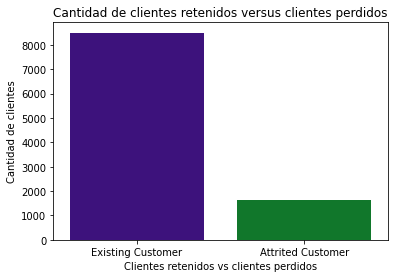

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

transactions_df = transactions.select("Attrition_Flag").toPandas()
colors = ['#39008E', '#008823']
sns.set_palette(sns.color_palette(colors))
sns.countplot(x="Attrition_Flag", data=transactions_df)
plt.title("Cantidad de clientes retenidos versus clientes perdidos")
plt.ylabel("Cantidad de clientes")
plt.xlabel("Clientes retenidos vs clientes perdidos");

#### 4.2. Agregando una variable representando el peso de cada categoría

A seguir, vamos a computar los pesos de cada categoría de la variable de salida y colocarlos en una nueva columna denominada `weight`

In [0]:
import numpy as np
from itertools import chain

# Computar los pesos
y_collect = transactions.select("Attrition_Flag").groupBy("Attrition_Flag").count().collect()
unique_y = [x["Attrition_Flag"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]
class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}

# Crear la nueva columna de pesos
mapping_expr = f.create_map([f.lit(x) for x in chain(*class_weights_spark.items())])
transactions = transactions.withColumn("weight", mapping_expr[f.col("Attrition_Flag")])

# Mostrar el resultado con la nueva columna
transactions.select("Attrition_Flag", "weight").distinct().toPandas()

,Attrition_Flag,weight
0,Attrited Customer,3.112170
1,Existing Customer,0.595706


#### 4.3. Explorando las variables categóricas

Examinaremos las variable categóricas para detectar presencia de valores desconocidos, y la proporción de estos en la variable de salida.

In [0]:
# Seleccionar las columnas categóricas
meta = transactions.schema.fields
columnList = [field.name for field in transactions.schema.fields 
              if isinstance(field.dataType, t.StringType)]

# Seleccionar valores únicos en cada columna
for column in columnList:
    print("Categorias de {}: {}".format(column, transactions.select(column).distinct().rdd.flatMap(lambda x: x).collect()))

Categorias de Attrition_Flag: ['Existing Customer', 'Attrited Customer']
Categorias de Gender: ['F', 'M']
Categorias de Education_Level: ['High School', 'Unknown', 'Uneducated', 'Post-Graduate', 'Doctorate', 'Graduate', 'College']
Categorias de Marital_Status: ['Unknown', 'Married', 'Divorced', 'Single']
Categorias de Income_Category: ['$120K +', '$60K - $80K', '$80K - $120K', 'Unknown', '$40K - $60K', 'Less than $40K']
Categorias de Card_Category: ['Platinum', 'Silver', 'Blue', 'Gold']


In [0]:
total_existing = transactions.filter(transactions["Attrition_Flag"] == "Existing Customer").count()
total_attrited = transactions.filter(transactions["Attrition_Flag"] == "Attrited Customer").count()

for column in columnList:
    if transactions.select(column).filter(transactions[column] == "Unknown").count() == 0:
        pass
    else:
        print("Clientes con la variable {} desconocida representan el {:.2f}% de los clientes perdidos y el {:.2f}% de los clientes existentes".format(column, transactions.select(column).filter((transactions["Attrition_Flag"] == "Existing Customer") & (transactions[column] == "Unknown")).count() / total_existing * 100, transactions.select(column).filter((transactions["Attrition_Flag"] == "Attrited Customer") & (transactions[column] == "Unknown")).count() / total_attrited * 100))

Clientes con la variable Education_Level desconocida representan el 14.86% de los clientes perdidos y el 15.73% de los clientes existentes
Clientes con la variable Marital_Status desconocida representan el 7.29% de los clientes perdidos y el 7.93% de los clientes existentes
Clientes con la variable Income_Category desconocida representan el 10.88% de los clientes perdidos y el 11.49% de los clientes existentes


### 5. Ingeniería de características (feature engineering)

#### 5.1. Codificación de variables categóricas ordinales con StringIndexer

La codificación es el proceso de transformar una variable categórica que no sea numérica, con el objetivo de sea reconocido por el algoritmo de machine learning.

El **StringIndexer** es la única opción para codificar variable categóricas ordinales. El transformador puede ordenar la variable de dos formas:
* Por frecuencia, y
* Por order alfabética.

La forma de ordenar las categorías está definida por el atributo "stringOrderType". Si quisieramos transformar las variables `Education_Level`, `Income_Category` y `Card_Category`, y que estén ordenadas por la frecuencia (descendientes), lo haríamos de la siguiente manera:

In [0]:
from pyspark.ml.feature import StringIndexer

# Definir las columnas de entrada y de salida
inputcols = ['Education_Level', 'Income_Category', 'Card_Category']
outputcols=['Education_Level_cod', 'Income_Category_cod', 'Card_Category_cod']

# Aplicar el StringIndexer
indexer = StringIndexer(inputCols=inputcols, outputCols=outputcols, handleInvalid='error', stringOrderType='frequencyDesc')
transactions = indexer.fit(transactions).transform(transactions).drop('Education_Level', 'Income_Category', 'Card_Category')

# Visualizar el resultado
transactions.select("Education_Level_cod").limit(10).toPandas()

,Education_Level_cod
0,1.0
1,0.0
2,0.0
3,1.0
4,3.0
5,0.0
6,2.0
7,1.0
8,3.0
9,0.0


#### 5.2. Codificación de variables categóricas nominales con OneHotEncoder

El **One Hot Encoder** es un método de codificación que mapea los índices a un vector de representación binaria. Sirve para representar variables nominales de manera adecuada para la mayoría de los algoritmos de machine learning.

El OneHotEncoder del Spark ML es particularmente diferente de los transformadores de otras librerías de machine learning, ya que trabaja con índices y se utiliza del resultado del StringIndexer para crear los vectores, lo que diferencia del tradicional estilo de creación de columnas *dummies* en otras librerías.

El resultado del OneHotEncoder es una matriz de vectores escasos o dispersos. Esto suele ser poco intuitivo, ya que transforma los atributos en lugar de mantenerlos a diferencia del Scikit-Learn.

La transformación por OneHotEncoder se realiza de la siguiente manera:

In [0]:
from pyspark.ml.feature import OneHotEncoder

inputcols = ['Gender', 'Marital_Status']
outputcolsindexer = ['Gender_idx', 'Marital_Status_idx']
outputcolsonehot = ['Gender_cod', 'Marital_Status_cod']

# Aplicar el StringIndexer
indexer = StringIndexer(inputCols=inputcols, outputCols=outputcolsindexer, handleInvalid='error', stringOrderType='frequencyDesc')
transactions = indexer.fit(transactions).transform(transactions).drop('Gender', 'Marital_Status')

# Aplicar el OneHotEncoder
onehot = OneHotEncoder(inputCols=outputcolsindexer, outputCols = outputcolsonehot)
transactions = onehot.fit(transactions).transform(transactions).drop('Gender_idx', 'Marital_Status_idx')

# Visualizar el resultado
transactions.select(outputcolsonehot).show(10)

+-------------+------------------+
|   Gender_cod|Marital_Status_cod|
+-------------+------------------+
|    (1,[],[])|     (3,[0],[1.0])|
|(1,[0],[1.0])|     (3,[1],[1.0])|
|    (1,[],[])|     (3,[0],[1.0])|
|(1,[0],[1.0])|     (3,[2],[1.0])|
|    (1,[],[])|     (3,[0],[1.0])|
|    (1,[],[])|     (3,[0],[1.0])|
|    (1,[],[])|     (3,[0],[1.0])|
|    (1,[],[])|     (3,[2],[1.0])|
|    (1,[],[])|     (3,[1],[1.0])|
|    (1,[],[])|     (3,[1],[1.0])|
+-------------+------------------+
only showing top 10 rows



#### 5.3. Codificación de la variable de salida

Se codificará la variable de salida mediante el StringIndexer:

In [0]:
# Definir las variables de entrada y de salida
inputcol = "Attrition_Flag"
outputcol = "label"

# Aplicar el StringIndexer
indexer = StringIndexer(inputCol=inputcol, outputCol=outputcol, handleInvalid='error', stringOrderType='frequencyDesc')
transactions = indexer.fit(transactions).transform(transactions).drop('Attrition_Flag')

#### 5.4. Concatenación de los atributos mediante VectorAssembler

In [0]:
from pyspark.ml.feature import VectorAssembler

# Definir las variables de entrada y de salida
inputcols = transactions.drop("label", "weight").columns
outputcol = "features_raw"

# Aplicar el VectorAssembler
assembler = VectorAssembler(inputCols = inputcols, outputCol=outputcol)
transactions = assembler.transform(transactions)

# Eliminar las otras columnas
for column in inputcols:
    transactions = transactions.drop(column)
    
# Visualizar el resultado
transactions.select("features_raw").show(5, False)

+-----------------------------------------------------------------------------------------------------------+
|features_raw                                                                                               |
+-----------------------------------------------------------------------------------------------------------+
|[45.0,3.0,39.0,5.0,1.0,3.0,12691.0,777.0,11914.0,1.335,1144.0,42.0,1.625,0.061,1.0,3.0,0.0,0.0,1.0,0.0,0.0]|
|[49.0,5.0,44.0,6.0,1.0,2.0,8256.0,864.0,7392.0,1.541,1291.0,33.0,3.714,0.105,0.0,0.0,0.0,1.0,0.0,1.0,0.0]  |
|[51.0,3.0,36.0,4.0,1.0,0.0,3418.0,0.0,3418.0,2.594,1887.0,20.0,2.333,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0]      |
|[40.0,4.0,34.0,3.0,4.0,1.0,3313.0,2517.0,796.0,1.405,1171.0,20.0,2.333,0.76,1.0,0.0,0.0,1.0,0.0,0.0,1.0]   |
|[40.0,3.0,21.0,5.0,1.0,0.0,4716.0,0.0,4716.0,2.175,816.0,28.0,2.5,0.0,3.0,3.0,0.0,0.0,1.0,0.0,0.0]         |
+-----------------------------------------------------------------------------------------------------------+
only showi

#### 5.5. Standarización de las variables con MinMaxScaler

In [0]:
from pyspark.ml.feature import MinMaxScaler

# Definir las variables de entrada y salida
inputcol = "features_raw"
output = "features"

# Definir el MinMaxScaler
minmaxscaler = MinMaxScaler(min=0.0, max=1.0, inputCol=inputcol, outputCol=output)

# Aplicar el MinMaxScaler
transactions = minmaxscaler.fit(transactions).transform(transactions).drop("features_raw")

# Visualizar el resultado
transactions.select("features").show(5, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.40425531914893614,0.6000000000000001,0.6046511627906976,0.8,0.1666666666

In [0]:
transactions.show(10)

+------------------+-----+--------------------+
|            weight|label|            features|
+------------------+-----+--------------------+
|0.5957058823529412|  0.0|[0.40425531914893...|
|0.5957058823529412|  0.0|[0.48936170212765...|
|0.5957058823529412|  0.0|[0.53191489361702...|
|0.5957058823529412|  0.0|[0.29787234042553...|
|0.5957058823529412|  0.0|[0.29787234042553...|
|0.5957058823529412|  0.0|[0.38297872340425...|
|0.5957058823529412|  0.0|[0.53191489361702...|
|0.5957058823529412|  0.0|[0.12765957446808...|
|0.5957058823529412|  0.0|[0.23404255319148...|
|0.5957058823529412|  0.0|[0.46808510638297...|
+------------------+-----+--------------------+
only showing top 10 rows



### 6. Aplicando un modelo sencillo de regresión logística

In [0]:
from pyspark.ml.classification import LogisticRegression

# Definir la columna de pesos
weight = "weight"

# Creación del modelo
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0, weightCol=weight)

# Aplicación del modelo
predictions = lr.fit(transactions).transform(transactions)

# Ver las columnas de predictions
predictions.columns

Out[16]: ['weight', 'label', 'features', 'rawPrediction', 'probability', 'prediction']

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Definir las columnas de predicciones y de labels
rawprediction = "rawPrediction"
label = "label"

# Evaluar con MulticlassClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawprediction, labelCol=label, weightCol=weight, metricName="areaUnderROC")
print("La precisión del modelo es del {:0.2f}%".format(evaluator.evaluate(predictions)*100))

La precisión del modelo es del 89.21%


In [0]:
# Liberar memoria para el siguiente ejemplo
transactions.unpersist()
del transactions
spark.catalog.clearCache()

# Ejemplo 2: preprocesando datos de Optiver para predecir la volatilidad de las opciones financieras

#### 1. Sobre el problema
Como líder mundial en creación de mercados electrónicos, Optiver se dedica a mejorar continuamente los mercados financieros, creando un mejor acceso y mejores precios para opciones, ETF, acciones en efectivo, bonos y divisas extranjeras en numerosas bolsas de todo el mundo, a través de sus modelos predictivos. Optiver desea ver maneras de mejorar sus modelos de predicción de los precios antes de evaluarlos con datos del mercado en tiempo real.

En este desafio, es necesario crear un modelo que logre capturar los diversos aspectos que afectan a la volatilidad de corto plazo de los precios. El gran problema en este caso no está en la construcción de un mejor algoritmo para el modelo de predicción, sino en la etapa del **procesamiento de los datos** y en el **feature engineering**.

In [0]:
# access_key = "your_access_key"
# secret_key = "your_secret_key"

# # Mount "optiver-realized-volatility-pyspark" bucket on databricks
# encoded_secret_key = secret_key.replace("/", "%2F")
# aws_bucket_name = "optiver-realized-volatility-pyspark"
# mount_name = "data"
# dbutils.fs.mount("s3a://%s:%s@%s" % (access_key, encoded_secret_key, aws_bucket_name), "/mnt/%s" % mount_name)
# display(dbutils.fs.ls("/mnt/%s" % mount_name))

#### 2. Sobre los datos
Los datos del **book** y **trade** fueron proporcionados como archivos en formato parquet y consistieron en observaciones que contenían precios y volúmenes de oferta y demanda. Los datos de cada *book* y *trade* se particionaron por **stock_id**, y cada bucket en una partición representaba el *timestamp* de los datos del respectivo *stock* como **time_id**.

Los datos del **book** consistían en variables que representaban la intención del mercado en un momento dado. Entre estas variables, se encontraban los precios de las intenciones de compras y los precios de intenciones de venta, junto con los respectivos volúmenes.

In [0]:
df_book_train = spark.read.parquet("book_train.parquet").filter(f.col("stock_id").between(0, 2))
df_book_train.limit(5).toPandas()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.000607,1.000769,1.000526,1.00085,100,200,1,1,2
1,5,1,1.000526,1.000769,1.000445,1.00085,1,200,100,101,2
2,5,2,1.000526,1.000769,1.000364,1.00085,1,300,112,101,2
3,5,3,1.000607,1.000769,1.000526,1.00085,100,300,1,1,2
4,5,4,1.000526,1.000769,1.000445,1.00085,1,300,300,101,2


Los datos del **trade** consistían en variables que representaban las ejecuciones de las intenciones en un determinado periodo. Las diferencias en segundos entre la orden de compra/venta y su ejecución estaban representadas por la variable `seconds_in_bucket` en los datos.

In [0]:
df_trade_train = spark.read.parquet("trade_train.parquet").filter(f.col("stock_id").between(0, 2))
df_trade_train.limit(5).toPandas()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,0,1.000688,101,2,2
1,5,5,1.000607,3,2,2
2,5,8,1.000526,100,1,2
3,5,10,1.000526,2,2,2
4,5,13,1.000526,1,1,2


Asimismo, se proporcionaron los datos de entrenamiento, que consistían de valores de verdad fundamentales (*ground truth*) de la volatilidad realizada en cada time_id y row_id. Utilizaremos estos valores como variables de salida.

In [0]:
train = spark.read.option("header", True).option("inferSchema", True).csv("train.csv").filter(f.col("stock_id").between(0, 2))
train.limit(5).toPandas()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


### 3. Preprocesamiento y feature engineering
La **feature engineering** resulta ser fundamental para generar datos de entrada que serían de gran utilidad para nuestro modelo predictivo. 
La idea aquí es modelar las señales del mercado a partir de los datos del *book* y *trade*, utilizando técnicas y herramientas de preprocesamiento y feature engineering que nos ofrece Spark SQL y Spark ML.

#### 3.1 Generación de las variables de salida
Antes de proceder, vamos a generar los datos de la variable de salida, que representa la volatilidad realizada (realized volatility), cuya fórmula es la siguiente: $$
\sigma = \sqrt{\sum_{t}r_{t-1, t}^2}
$$

Donde:
* *t* es un periodo de tiempo determinado (en ventanas de 10 minutos)
* *r* es el rendimiento logarítmico de las opciones financieras entre los periodos

In [0]:
# Especificar una función de ventana
windowSpec = Window.partitionBy("time_id").orderBy("stock_id")

# Calcular el WAP
df_book_train = df_book_train.withColumn("wap", (f.col("bid_price1") * f.col("ask_size1") + f.col("ask_price1") * f.col("bid_size1"))/(f.col("bid_size1") + f.col("ask_size1")))

# Calcular los retornos logaritmicos
df_book_train = df_book_train \
                .withColumn('prev_return', f.lag(f.col("wap")).over(windowSpec)) \
                .withColumn('log_return', f.log(f.col("wap") / f.col("prev_return"))) \
                .drop("prev_return")

# Calcular la volatilidad realizada de cada time_id
df_book_train = df_book_train\
    .withColumn("realized_volatility1", f.pow(f.col("log_return"),2)) \
    .withColumn("realized_volatility2", f.sum(f.col("realized_volatility1")).over(windowSpec)) \
    .withColumn("realized_volatility", f.sqrt(f.col("realized_volatility2"))) \
    .drop("realized_volatility2","realized_volatility1")

df_book_train.limit(5).toPandas()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return,realized_volatility
0,31,0,0.999815,1.000463,0.999722,1.000509,343,100,5,242,0,1.000316,NaN,0.002574
1,31,3,0.999815,1.000463,0.999769,1.000509,343,100,5,142,0,1.000316,0.000000,0.002574
2,31,11,0.999815,1.000509,0.999769,1.000601,343,142,5,100,0,1.000306,-0.000011,0.002574
3,31,27,0.999815,1.000509,0.999769,1.000601,243,142,5,100,0,1.000253,-0.000053,0.002574
4,31,31,0.999815,1.000509,0.999769,1.000601,243,142,5,125,0,1.000253,0.000000,0.002574


Los primeros valores de cada time_id serian nulos, ya que no existen valores anteriores en la ventana. Así que los eliminaremos:

In [0]:
# Eliminar valores nulos
df_book_train = df_book_train.dropna()

#### 3.2 Extracción de características
La feature extraction resulta ser fundamental para generar datos de entrada que serían de gran utilidad para nuestro modelo predictivo. 
Sobre los datos del *book* y *trade*, podríamos derivar otras variables que capturarían las dinámicas de la volatilidad bajo los siguientes supuestos:
- La falta de liquidez hace que el mercado fluctúe más de lo habitual.
- Un elevado desequilibrio en los volúmenes de compra y venta puede indicar una volatilidad creciente.
- Una mayor diferencia entre los precios de compra y de venta conduce a una mayor volatilidad debido a la falta de liquidez.
- Una mayor profundidad de mercado (volúmenes de compra y venta) generalmente conduce a menores fluctuaciones de precios.

En resumen, vamos a generar las variables denominadas `total_volume`, `ask_bid_spread` y `volume_imbalance` en los datos del *book*.

In [0]:
# Calcular el price spread
df_book_train = df_book_train \
    .withColumn("ask_bid_spread1", f.col("ask_price1") - f.col("bid_price1")) \
    .withColumn("ask_bid_spread2", f.col("ask_price2") - f.col("bid_price2"))

# Calcular en volumen total
df_book_train = df_book_train \
    .withColumn("total_volume", f.col("ask_size1") + f.col("ask_size2") + f.col("bid_size1") + f.col("bid_size2"))

# Calcular el desbalance en el volumen
df_book_train = df_book_train \
    .withColumn("volume_imbalance", f.abs((f.col("ask_size1") + f.col("ask_size2")) - (f.col("bid_size1") + f.col("bid_size2"))))

df_book_train.limit(5).toPandas()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap,log_return,realized_volatility,ask_bid_spread1,ask_bid_spread2,total_volume,volume_imbalance
0,31,3,0.999815,1.000463,0.999769,1.000509,343,100,5,142,0,1.000316,0.000000,0.002574,0.000648,0.000740,590,106
1,31,11,0.999815,1.000509,0.999769,1.000601,343,142,5,100,0,1.000306,-0.000011,0.002574,0.000694,0.000833,590,106
2,31,27,0.999815,1.000509,0.999769,1.000601,243,142,5,100,0,1.000253,-0.000053,0.002574,0.000694,0.000833,490,6
3,31,31,0.999815,1.000509,0.999769,1.000601,243,142,5,125,0,1.000253,0.000000,0.002574,0.000694,0.000833,515,19
4,31,40,0.999815,1.000463,0.999769,1.000509,243,101,5,142,0,1.000273,0.000020,0.002574,0.000648,0.000740,491,5


#### 3.3. Agregaciones con groupBy

Antes de unir las tablas del book y trade, es necesario realizar agregaciones a los datos mediante una columna denominada `row_id`, que representa cada registro único del `time_id` y `stock_id`, y que debe ser generado mediante la concatenación de los dos IDs.

In [0]:
# Crear la columna row_id para la tabla del book
df_book_train = df_book_train.withColumn("stock_id_str", df_book_train["stock_id"].cast('string')) \
                 .withColumn("time_id_str", df_book_train["time_id"].cast('string')) \
                 .withColumn("row_id", f.concat("stock_id_str", f.lit("-"), "time_id_str")) \
                 .drop("stock_id", "time_id", "stock_id_str", "time_id_str")

df_trade_train = df_trade_train.withColumn("stock_id_str", df_trade_train["stock_id"].cast('string')) \
                 .withColumn("time_id_str", df_trade_train["time_id"].cast('string')) \
                 .withColumn("row_id", f.concat("stock_id_str", f.lit("-"), "time_id_str")) \
                 .drop("stock_id", "time_id", "stock_id_str", "time_id_str")

train = train.withColumn("stock_id_str", train["stock_id"].cast('string')) \
                 .withColumn("time_id_str", train["time_id"].cast('string')) \
                 .withColumn("row_id", f.concat("stock_id_str", f.lit("-"), "time_id_str")) \
                 .drop("stock_id", "time_id", "stock_id_str", "time_id_str")

In [0]:
# Alterar el nombre de la columna seconds_in_bucket en la tabla de trade
df_trade_train = df_trade_train.withColumnRenamed("seconds_in_bucket", "seconds_in_bucket_trade")

In [0]:
# Calcular el promedio en cada columna del book
df_book_train = df_book_train.groupBy("row_id").avg()

# Calcular el promedio en cada columna del trade
df_trade_train = df_trade_train.groupBy("row_id").avg()

In [0]:
# Hacer un join entre las tablas (train y book)
train = train.join(df_book_train, train["row_id"] == df_book_train["row_id"]).drop(df_book_train["row_id"]) \
             .join(df_trade_train, train["row_id"] == df_trade_train["row_id"]).drop(df_trade_train["row_id"])

In [0]:
train.limit(10).toPandas()

,target,row_id,avg(seconds_in_bucket),avg(bid_price1),avg(ask_price1),avg(bid_price2),avg(ask_price2),avg(bid_size1),avg(ask_size1),avg(bid_size2),...,avg(log_return),avg(realized_volatility),avg(ask_bid_spread1),avg(ask_bid_spread2),avg(total_volume),avg(volume_imbalance),avg(seconds_in_bucket_trade),avg(price),avg(size),avg(order_count)
0,0.006113,0-1322,286.541833,0.998305,1.000744,0.998042,1.001419,79.689243,83.374502,61.872510,...,-6.871912e-07,0.011045,0.002439,0.003377,328.549801,110.023904,266.735294,0.998625,153.264706,4.970588
1,0.002329,2-4364,303.678284,0.998666,0.998882,0.998498,0.999071,123.053619,110.798928,143.351206,...,-1.197342e-06,0.006107,0.000215,0.000574,482.219839,129.581769,303.831461,0.998681,162.528090,2.505618
2,0.002268,0-6939,322.038732,0.999712,1.000274,0.999601,1.000475,97.841549,32.841549,85.200704,...,1.174528e-06,0.002258,0.000561,0.000874,241.827465,137.897887,307.407407,0.999971,39.481481,2.037037
3,0.001357,2-10708,295.911824,1.000412,1.000557,1.000327,1.000641,178.659319,255.989980,206.170341,...,-6.253809e-07,0.005487,0.000145,0.000314,847.807615,230.224449,275.463918,1.000550,232.288660,3.463918
4,0.001851,1-14423,286.300000,0.999754,0.999960,0.999652,1.000065,242.572917,140.479167,226.602083,...,3.683135e-07,0.002862,0.000206,0.000413,796.037500,240.504167,291.542056,0.999890,202.588785,3.317757
5,0.006997,1-15906,287.455764,1.001083,1.002435,1.000911,1.002583,89.576408,124.554960,72.042895,...,3.759951e-05,0.023199,0.001352,0.001672,382.324397,133.895442,278.800000,1.001279,267.254545,5.763636
6,0.005478,1-17008,302.023474,0.994690,0.995183,0.994459,0.995364,136.387324,139.215962,143.793427,...,-3.139935e-06,0.007223,0.000494,0.000905,572.593897,150.931925,324.585106,0.994755,147.170213,2.404255
7,0.002460,2-30134,303.588339,0.999852,0.999948,0.999778,1.000022,772.107774,372.222615,827.994700,...,1.416295e-06,0.003117,0.000097,0.000244,2379.220848,1027.860424,310.834783,0.999932,333.530435,3.643478
8,0.002067,0-30793,282.145455,1.000536,1.001513,1.000283,1.001659,195.921212,114.321212,107.909091,...,-4.076191e-06,0.002804,0.000977,0.001376,478.133333,187.018182,331.437500,1.001386,187.687500,5.250000
9,0.002476,2-1322,321.959335,0.999404,0.999819,0.999298,0.999913,182.234750,201.016636,172.086876,...,3.889499e-06,0.014938,0.000415,0.000616,746.822551,163.628466,318.993464,0.999532,231.130719,3.235294


#### 3.4. Vectorización con VectorAssembler

Vamos a agregar los datos de acuerdo a la media y desviación de todas las features que hemos generado, por stock_id y time_id

In [0]:
# Definir las variables de entrada y de salida
inputcols = train.drop("target", "row_id").columns
outputcol = "features_raw"

# Aplicar el VectorAssembler
assembler = VectorAssembler(inputCols = inputcols, outputCol=outputcol)
train = assembler.transform(train)

# Eliminar las otras columnas
for column in inputcols:
    train = train.drop(column)
    
# Visualizar el resultado
train.select("features_raw").show(5, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_raw                                                                                                                                                                                                                                                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### 3.5. Estandarización con StandardScaler

In [0]:
from pyspark.ml.feature import StandardScaler

# Definir las variables de entrada y salida
inputcol = "features_raw"
output = "features"

# Definir el MinMaxScaler
standardscaler = StandardScaler(inputCol=inputcol, outputCol=output)

# Aplicar el MinMaxScaler
train = standardscaler.fit(train).transform(train).drop("features_raw")

# Visualizar el resultado
train.select("features").show(5, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                  |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", False) # Ocultar el mensaje de warning del pyarrow
train = train.withColumnRenamed("target", "label").drop("row_id")
train.limit(10).toPandas()

,label,features
0,0.006113,"[19.227794251738167, 308.62249425623, 307.3058..."
1,0.002329,"[20.377700221233273, 308.734324170974, 306.734..."
2,0.002268,"[21.609739945773608, 309.05764968626966, 307.1..."
3,0.001357,"[19.856548025617318, 309.27387559488955, 307.2..."
4,0.001851,"[19.211566572987845, 309.07052041324664, 307.0..."
5,0.006997,"[19.289121719585182, 309.48133433764383, 307.8..."
6,0.005478,"[20.266657634591265, 307.5049067175754, 305.59..."
7,0.002460,"[20.371664651617472, 309.10074181122116, 307.0..."
8,0.002067,"[18.932784433342352, 309.31220637498575, 307.5..."
9,0.002476,"[21.60441211946301, 308.9622072398843, 307.021..."


### Conclusiones
Con este notebook, hemos logrado el objetivo de explorar las herramientas más comúnes de preprocesamiento e ingeniería de características continuas y categóricas con Spark ML mediante ejemplos de casos reales. Hemos visto las maneras de normalizar o estandarizar los datos continuos con **StandardScaler** y **MaxMinScaler** y de indexar los datos categóricos no numéricos con **String Indexer**. También hemos visto cómo aprovechar las funciones del Spark SQL para la extracción de características.